In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

## Import Data

In [6]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=["pickup_datetime"])
df.dropna(inplace=True)

pickup_dt = df.pickup_datetime.dt
df["year"] = pickup_dt.year
df["month"] = pickup_dt.month
df["day"] = pickup_dt.dayofweek
df["hour"] = pickup_dt.hour
df.drop(columns=["pickup_datetime"], inplace=True)

df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude'], inplace=True)

df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


## Dataset Splitting

In [8]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

## Training

In [9]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [10]:
rsp.enet_params

{'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['year', 'passenger_count', 'distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['month', 'day' ,'hour']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])


model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   36.9s finished
C:\Users\Tes\miniconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:2970: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__alpha': 0.00012575549573395252, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.8095010461397156, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.719461184953708 0.7159820223249377 0.746594251922585


C:\Users\Tes\miniconda3\envs\jcopml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188706.03227924608, tolerance: 140.34017623508723
  positive)


## Feature Importance

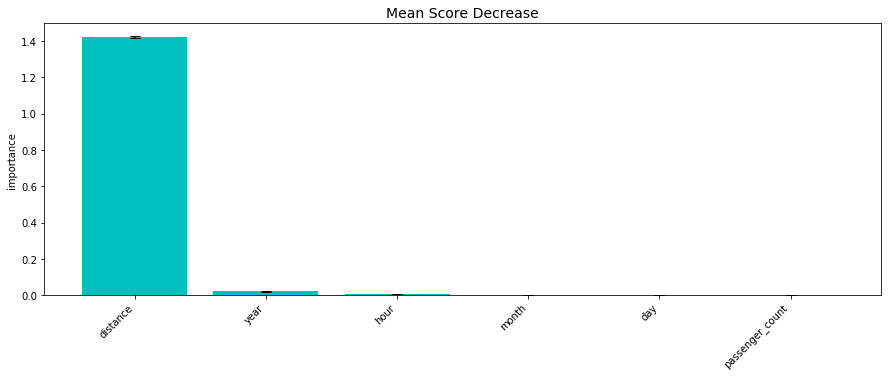

In [14]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

## Evalutation

In [16]:
from jcopml.plot import plot_residual

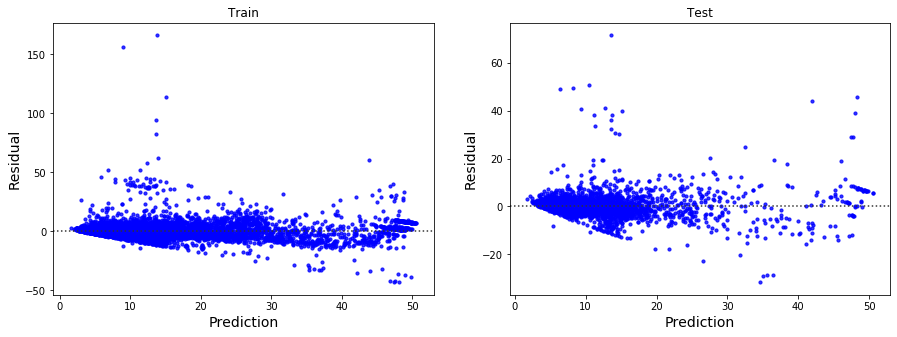

In [17]:
plot_residual(X_train, y_train, X_test, y_test, model)

### Masih aja ada unbalanced, mari kita cek datanya

In [19]:
X_train.head()

,passenger_count,year,month,day,hour,distance
7539,1.0,2011,6,1,22,0.000000
578,3.0,2010,3,3,10,0.009293
8056,5.0,2010,4,0,8,0.048951
11761,1.0,2014,11,0,22,0.027145
15531,1.0,2012,12,5,13,0.010498


In [20]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['fare'] = y_train
df_analysis['error'] = error 
df_analysis.sort_values("error", ascending=False).head(10)

,passenger_count,year,month,day,hour,distance,fare,error
1335,1.0,2013,1,2,20,0.000000,180.00,166.176910
1483,1.0,2009,8,4,21,0.000416,165.00,156.085000
6630,1.0,2014,5,4,1,0.000000,128.83,113.788091
14142,1.0,2014,12,4,10,0.045860,108.00,94.341823
12915,1.0,2011,9,2,1,0.000000,96.00,82.298160
10524,1.0,2010,5,1,14,0.000000,75.80,61.871194
12349,1.0,2010,5,5,15,0.434492,104.67,60.737043
1494,1.0,2009,9,1,14,0.000031,70.00,57.640156
2432,1.0,2012,11,4,1,0.003817,58.60,51.791577
2346,1.0,2009,2,5,0,0.000000,63.00,51.652139
